<a href="https://colab.research.google.com/github/SebastianJanampa/DETRPose/blob/main/DETRPose_tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from IPython.display import clear_output

!git clone https://github.com/SebastianJanampa/DETRPose.git
!pip install -r /content/DETRPose/requirements.txt
%cp -r /content/DETRPose/examples/ /content/

clear_output()

In [2]:
!pip install --upgrade pandas==2.0 numpy==1.24
clear_output()

In [3]:
try:
  import numpy as np
  np.rec
except:
  print('Restarting runtime!')
  import os
  os.kill(os.getpid(), 9)

In [4]:
import os, sys
sys.path.append('/content/DETRPose')
sys.path.append('/content/DETRPose/tools/inference')

In [5]:
from DETRPose.src.core import LazyConfig, instantiate
from DETRPose.tools.inference.annotator import Annotator
from DETRPose.tools.inference.annotator_crowdpose import AnnotatorCrowdpose

config_models = {
    # For COCO2017
    'n': '/content/DETRPose/configs/detrpose/detrpose_hgnetv2_n.py',
    's': '/content/DETRPose/configs/detrpose/detrpose_hgnetv2_s.py',
    'm': '/content/DETRPose/configs/detrpose/detrpose_hgnetv2_m.py',
    'l': '/content/DETRPose/configs/detrpose/detrpose_hgnetv2_l.py',
    'x': '/content/DETRPose/configs/detrpose/detrpose_hgnetv2_x.py',
    # For CrowdPose
    'n_crowdpose': '/content/DETRPose/configs/detrpose/detrpose_hgnetv2_n_crowdpose.py',
    's_crowdpose': '/content/DETRPose/configs/detrpose/detrpose_hgnetv2_s_crowdpose.py',
    'm_crowdpose': '/content/DETRPose/configs/detrpose/detrpose_hgnetv2_m_crowdpose.py',
    'l_crowdpose': '/content/DETRPose/configs/detrpose/detrpose_hgnetv2_l_crowdpose.py',
    'x_crowdpose': '/content/DETRPose/configs/detrpose/detrpose_hgnetv2_x_crowdpose.py',
}

model_name = 'm'
config_path = config_models[model_name]
download_url = f'https://github.com/SebastianJanampa/DETRPose/releases/download/model_weights/detrpose_hgnetv2_{model_name}.pth'
weigths_folder = './weights'
if 'crowdpose' in model_name:
    Drawer = AnnotatorCrowdpose
else:
    Drawer = Annotator

In [6]:
import torch
import torch.nn as nn

cfg = LazyConfig.load(config_path)
if hasattr(cfg.model.backbone, 'pretrained'):
        cfg.model.backbone.pretrained = False

state = torch.hub.load_state_dict_from_url(download_url, map_location='cpu', model_dir=weigths_folder)
model = instantiate(cfg.model)
postprocessor = instantiate(cfg.postprocessor)

checkpoint = torch.load(f"{weigths_folder}/detrpose_hgnetv2_{model_name}.pth", map_location='cpu')
model.load_state_dict(checkpoint['model'], strict=True)

class Model(nn.Module):
  def __init__(self):
    super().__init__()
    self.model = model.deploy()
    self.postprocessor = postprocessor.deploy()

  def forward(self, images, orig_target_sizes):
    outputs = self.model(images)
    outputs = self.postprocessor(outputs, orig_target_sizes)
    return outputs

model = Model()

Downloading: "https://github.com/SebastianJanampa/DETRPose/releases/download/model_weights/detrpose_hgnetv2_m.pth" to ./weights/detrpose_hgnetv2_m.pth
100%|██████████| 81.2M/81.2M [00:00<00:00, 117MB/s]


In [7]:
import torchvision.transforms as T
transforms = T.Compose(
        [
            T.Resize((640, 640)),
            T.ToTensor(),
        ]
    )

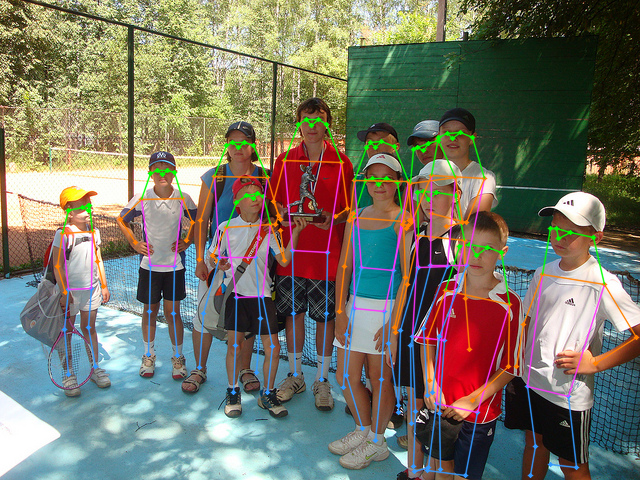

In [8]:
from PIL import Image
from copy import deepcopy
from google.colab.patches import cv2_imshow

device = 'cuda' if torch.cuda.is_available() else 'cpu'
thrh = 0.5 # threshold
model.to(device)
model.eval()

img_file = 'examples/example1.jpg'
im_pil = Image.open(img_file).convert("RGB")

w, h = im_pil.size
orig_size = torch.tensor([[w, h]]).to(device)
annotator = Drawer(deepcopy(im_pil))

im_data = transforms(im_pil).unsqueeze(0).to(device)

output = model(im_data, orig_size)
scores, labels, keypoints = output

scores, labels, keypoints = scores[0], labels[0], keypoints[0]
for kpt, score in zip(keypoints, scores):
    if score > thrh:
        annotator.kpts(
            kpt,
            [h, w]
            )

cv2_imshow(annotator.result())